# Intro

In [10]:
import matplotlib.pyplot as plt

results = {}

## Offline Decision Tree - sklearn



Model accuracy: 0.9778


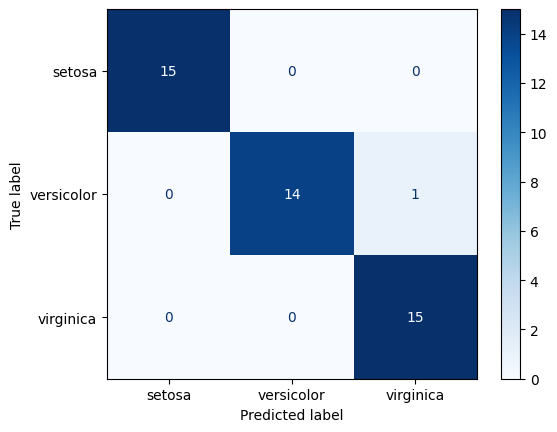

In [9]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

label_mapping = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, stratify=iris.target, random_state=42
)
offline_dt = DecisionTreeClassifier(random_state=0)
offline_dt.fit(X_train, y_train)
y_pred = offline_dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy:.4f}')
cm = confusion_matrix(y_test, y_pred, labels=offline_dt.classes_)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(map(label_mapping.get, offline_dt.classes_)))
disp.plot(cmap=plt.cm.Blues)
plt.show()

results["offline_decision_tree"] = dict(accuracy=accuracy,
           cm_plot=disp)

## Online Hoeffding Tree - river

Split on petal width (cm)	 Parent: NoneType
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on sepal width (cm)	 Parent: petal width (cm)
Model accuracy: 0.8859
    0    1    2   
0   46    3    0  
1    4   43    3  
2    0    7   43  


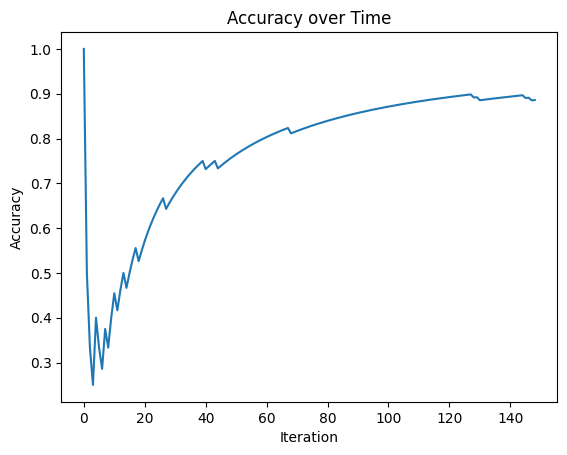

In [8]:
from river.tree import HoeffdingTreeClassifier
from river.stream import iter_sklearn_dataset
from river.metrics import Accuracy

hoeffding_tree = HoeffdingTreeClassifier(tau=1.5, grace_period=3)
metric = Accuracy()
accuracy_over_time = []

for x, y in iter_sklearn_dataset(iris, shuffle=True, seed=42):
    y_pred = hoeffding_tree.predict_one(x)
    if y_pred is not None:
        metric.update(y, y_pred)
        accuracy_over_time.append(metric.get())
    hoeffding_tree.learn_one(x, y)

accuracy = metric.get()
print(f'Model accuracy: {accuracy:.4f}')
print(metric.cm)

plt.plot(accuracy_over_time)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy over Time")
plt.show()

In [4]:
from river.evaluate import progressive_val_score

stream = iter_sklearn_dataset(iris, shuffle=True, seed=42)
hoeffding_tree = HoeffdingTreeClassifier(tau=1.5, grace_period=3)
metric = Accuracy()

progressive_val_score(dataset=stream, model=hoeffding_tree, metric=metric)
print(f"Accuracy: {metric.get():.3f}")
print(metric.cm)

Split on petal width (cm)	 Parent: NoneType
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on sepal width (cm)	 Parent: petal width (cm)
Accuracy: 0.886
    0    1    2   
0   46    3    0  
1    4   43    3  
2    0    7   43  


# Hoeffding Option Tree Implementation

$\delta = 0.955$

Accuracy: 0.899
    0    1    2   
0   48    1    0  
1    3   42    5  
2    2    4   44  


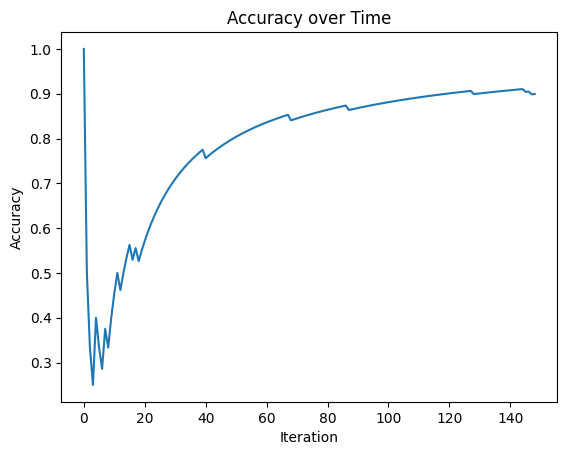

In [7]:
from hoeffding_option_tree import HoeffdingOptionTreeClassifier

stream = iter_sklearn_dataset(iris, shuffle=True, seed=42)
hoeffding_tree = HoeffdingOptionTreeClassifier(tau=1.5, grace_period=3,
                                               delta_prime=0.955,
                                               max_options=3)
metric = Accuracy()
accuracy_over_time = []
for x, y in iter_sklearn_dataset(iris, shuffle=True, seed=42):
    y_pred = hoeffding_tree.predict_one(x)
    if y_pred is not None:
        metric.update(y, y_pred)
        accuracy_over_time.append(metric.get())
    hoeffding_tree.learn_one(x, y)

print(f"Accuracy: {metric.get():.3f}")
print(metric.cm)
plt.plot(accuracy_over_time)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy over Time")
plt.show()